# Кейс:  a/b-тест для мобильного приложения

## Описание проекта

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Договорились принять решение по результатам A/B-теста.
Пользователей разбили на 3 группы:
-  246, 247 -- контрольные группы со старыми шрифтами;
- 248 -- экспериментальная с новыми шрифтами.

**Описание данных**

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|


Этапы:

Шаг 1. Загрузка данных
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовка данных
- Корректировка заголовков;
- Типы данных;
- Аномалии, пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

# Подключение библиотек

In [67]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px

import math
from scipy import stats as st

# Блок пользовательских функций

In [68]:
def z_test(df, group1, group2, event, alpha):
    """
    Функция для сравнения средних значений двух независимых выборок,
    чтобы определить, есть ли между ними статистически значимые различия.
    На вход подаются доли пользователей по группам, совершивших каждое из событий.
    На выходе получаем вывод о том, принимаем ли сформулированную гипотезу.

    """
    p1_ev = df.loc[group1, event]  # m_1
    p2_ev = df.loc[group2, event]  # m_2
    p1_us = df.loc[group1, 'count_users_group'] # n_1
    p2_us = df.loc[group2, 'count_users_group'] # n_2
    p1 = p1_ev / p1_us  # m1/n1
    p2 = p2_ev / p2_us  # m2/n2
    difference = p1 - p2 # m1/n1 - m2/n2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) #(m1 + m2) / (n1 + n2)
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Группы {} и {}. Событие -- {}. P-значение --  {:.2f}. Уровень значимости -- {}'.format(group1, group2, event, p_value, alpha ))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу -- между долями есть значимая разница")
        print()
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print()

# Загрузка данных

In [69]:
df = pd.read_csv('/content/sample_data/ab_testing.csv',
                 sep='\t')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [71]:
# просмотр уникальных значений категориальных признаков
for col in ['EventName', 'ExpId']:
    print(f'Признак {col}')
    print(df[col].unique())
    print()

Признак EventName
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']

Признак ExpId
[246 248 247]



Последовательность событий пользователя:

`MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful`

# Предварительная обработка данных

## Корректировка заголовков

In [72]:
df.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [73]:
df.rename(columns={'EventName': 'event_name',
                   'DeviceIDHash': 'user_id',
                   'EventTimestamp': 'event_time',
                   'ExpId': 'group_id'},
          inplace=True)

## Корректировка типов данных

In [74]:
df['event_date_time'] = pd.to_datetime(df['event_time'], # столбец с датой и временем
                                       origin='unix', # формат исходного представления даты и времени
                                       unit='s' # единицы, до которых приводится дата и время
                                       )

In [75]:
# удалим исходный столбец с датой и временем
df.drop(columns='event_time',
        inplace=True)

## Поиск дублирующихся записей

In [76]:
df.duplicated().sum()

np.int64(413)

In [77]:
# просмотр дублирующихся записей

df[df.duplicated()].sort_values(by='user_id')

,event_name,user_id,group_id,event_date_time
130558,MainScreenAppear,33176906322804559,248,2019-08-04 15:37:55
130995,OffersScreenAppear,33176906322804559,248,2019-08-04 15:49:23
104108,CartScreenAppear,34565258828294726,248,2019-08-03 18:33:41
159302,PaymentScreenSuccessful,54903596035630984,248,2019-08-05 13:27:52
176813,PaymentScreenSuccessful,77364241990273403,246,2019-08-05 22:38:52
...,...,...,...,...
56851,PaymentScreenSuccessful,9110248565804959041,248,2019-08-02 12:47:54
200171,PaymentScreenSuccessful,9160437016685643194,247,2019-08-06 15:13:36
199849,CartScreenAppear,9160437016685643194,247,2019-08-06 15:06:10
204830,PaymentScreenSuccessful,9187990861085277398,247,2019-08-06 17:01:28


In [78]:
# удалим все дублирующиеся записи, кроме последних
df.drop_duplicates(keep='last',
                   inplace=True)

## Поиск и обработка аномальных значений

In [79]:
(
df.groupby('user_id')
      .agg(count_event = ('event_name', 'count'))
      .sort_values(by='count_event', ascending=False)
      .head(20)
)
# видим, что имеются клиенты с аномально большим количество событий

,count_event
user_id,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221
3337471580007169353,1186
7738058666231999878,888
1055544042902443290,854
4713748699910253089,824


In [80]:
# срок совершения событий в целом
df['event_date_time'].max() - df['event_date_time'].min()

Timedelta('13 days 16:31:41')

In [81]:
# срок совершения событий по отдельному пользователю
(df.query('user_id == 6304868067479728361')['event_date_time'].max()
- df.query('user_id == 6304868067479728361')['event_date_time'].min())

Timedelta('6 days 01:25:23')

## Проверка условий корректности a/b теста

In [82]:
(df.groupby('group_id')
   .agg(count_users = ('user_id', 'nunique')))

,count_users
group_id,
246,2489
247,2520
248,2542


In [83]:
# множества, содержащие уникальные значения идентификаторов клиентов каждой группы
set_users_id_246 = set(df.query('group_id == 246')['user_id'].to_list())
set_users_id_247 = set(df.query('group_id == 247')['user_id'].to_list())
set_users_id_248 = set(df.query('group_id == 248')['user_id'].to_list())

# найдем общих пользователей, если они есть
set_users_id_246.intersection(set_users_id_247)
set_users_id_246.intersection(set_users_id_248)
set_users_id_247.intersection(set_users_id_248)

set()

## Выводы

- поскольку итоговые показатели проекта считаются на количество уникальных пользователей, то несколько пользователей с подозрительным количеством событий не окажут значимого влияния на результат;
- проверка корректности теста показала:
   - численность пользователей в группах примерно одинаковая;
   - общих пользователей в группах нет;
Таким образом, тест проведен корректно, можно приступать к исследовательскому анализу.


# Исследовательский анализ

In [84]:
# Cколько всего событий:
print(f"""Всего {df.event_name.nunique()} событий.
Это события: {', '.join(df.event_name.unique())}.""")
print()

# Сколько всего пользователей в логе:
print(f"""Всего уникальных пользователей {df.user_id.nunique()}.""")
print()

# Сколько в среднем событий приходится на пользователя:
print(f"""В среднем на одного пользователя приходится
               {int(df.event_name.count() / df.user_id.nunique())} события.""")
print()

# Период теста: максимальная и минимальная даты;
#гистограмма по дате и количеству событий.
print(f"""Период проведения теста:
Дата совершения первого события -- {df.event_date_time.min()}
Дата совершения последнего события -- {df.event_date_time.max()}.""")

Всего 5 событий.
Это события: MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial.

Всего уникальных пользователей 7551.

В среднем на одного пользователя приходится 
               32 события.

Период проведения теста:
Дата совершения первого события -- 2019-07-25 04:43:36
Дата совершения последнего события -- 2019-08-07 21:15:17.


## Диаграмма по дате и количеству событий

In [85]:
# выделим из даты и времени совершения события только дату
# в формате год-месяц-день

df['event_date'] = df['event_date_time'].dt.date

/tmp/ipython-input-2664294324.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



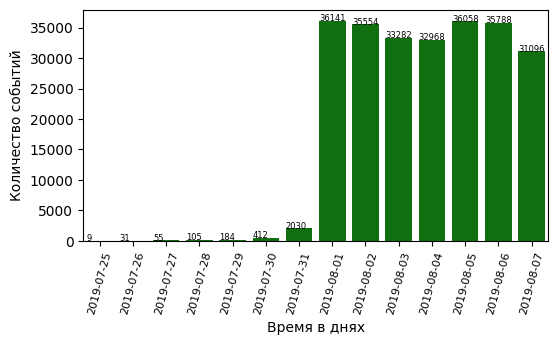

In [86]:
plt.figure(figsize=(6,3))
ax = sns.countplot(data=df,
                   x='event_date',
                   color='green');
ax.set_xlabel('Время в днях');
ax.set_ylabel('Количество событий');
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=75,
                   fontsize=8);
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(),
                                                  p.get_height()),
                fontsize=6)

По графику видим, что в первую неделю теста не все пользователи, видимо, принимали участие в нем.
В связи с этим полученные результаты нельзя считать адекватными первоначальному плану эксперимента.

Следует отфильтровать данные по дате, начиная с 2019-08-01.

In [87]:
df_ab = df[df.event_date >= dt.date(2019,8,1)]
# проверка
df_ab.event_date.agg(['min', 'max'])

,event_date
min,2019-08-01
max,2019-08-07


In [88]:
# сверим кол-во участников в каждой группе
(
df_ab.groupby('group_id')
     .agg(count_users = ('user_id', 'nunique'))
)

,count_users
group_id,
246,2484
247,2513
248,2537


# Анализ воронки событий

## Распределение событий

In [89]:
funnel_full = (
    df_ab.groupby(['event_name', 'group_id'], as_index=False)
         .agg(count_events = ('user_id', 'count'))
         .sort_values(by='count_events', ascending=False)
              )
funnel_full

,event_name,group_id,count_events
5,MainScreenAppear,248,40562
4,MainScreenAppear,247,39090
3,MainScreenAppear,246,37676
8,OffersScreenAppear,248,16387
2,CartScreenAppear,248,15179
7,OffersScreenAppear,247,15179
6,OffersScreenAppear,246,14767
0,CartScreenAppear,246,14690
1,CartScreenAppear,247,12434
11,PaymentScreenSuccessful,248,12085


In [90]:
# построим график воронки событий

fig = px.funnel(funnel_full,
                x='count_events',
                y='event_name',
                color='group_id')
fig.show()

## Кол-во пользователей, совершивших каждое событие

In [91]:
users_all = (
             df_ab.groupby(['event_name', 'group_id'], as_index=False)
             .agg(count_users = ('user_id', 'nunique'))
             .sort_values(by='count_users', ascending=False)
            )

users_all

,event_name,group_id,count_users
5,MainScreenAppear,248,2493
4,MainScreenAppear,247,2476
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542
8,OffersScreenAppear,248,1531
7,OffersScreenAppear,247,1520
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1238
2,CartScreenAppear,248,1230
9,PaymentScreenSuccessful,246,1200


In [92]:
# по каждой группе рассчитаем процент пользователей,
# совершивших каждое из событий

# найдем количество уникальных пользователей в каждой группе
df_count_users_group = (
                       df_ab.groupby('group_id')
                            .agg(count_users_group = ('user_id', 'nunique'))
                            .reset_index()
                       )

In [93]:
# собираем датафрейм для подсчета процентов
df_users_count_perc = (
                       pd.merge(users_all, df_count_users_group,
                                on='group_id',
                                how='inner')
                      )

df_users_count_perc['group_perc'] = (
(df_users_count_perc['count_users'] / df_users_count_perc['count_users_group']
    *100).round(2)
                                    )

df_users_count_perc[['group_id', 'event_name', 'group_perc']]

,group_id,event_name,group_perc
0,248,MainScreenAppear,98.27
1,247,MainScreenAppear,98.53
2,246,MainScreenAppear,98.63
3,246,OffersScreenAppear,62.08
4,248,OffersScreenAppear,60.35
5,247,OffersScreenAppear,60.49
6,246,CartScreenAppear,50.97
7,247,CartScreenAppear,49.26
8,248,CartScreenAppear,48.48
9,246,PaymentScreenSuccessful,48.31


In [94]:
# построим график воронки событий по пользователям

fig = go.Figure(go.Funnel(
        y = df_users_count_perc['event_name'],
        x = df_users_count_perc['count_users'],
        textposition = "inside",
        textinfo = "value+percent initial+percent previous+percent total")
        )
fig.show()


## Выводы



- глядя на график воронки событий, видно, что по группам 246,247 и 248 нет видимых различий по событию `PaymentScreenSuccessful`. Более того, пользователи экспериментальной группы совершали примерно столько же событий как и в контрольной группе 246;

- по графику воронки событий по уникальным пользователям видно, что распределение также не имеет значимых различий;

- почти половина пользователей теряется на шаге `OffersScreenAppear`, причем потери равномерны по экспериментальной и по контрольным группам;

- до оплаты доходит всего 46-48% пользователей.



# Анализ результатов эксперимента

Для анализа результатов эксперимента необходимо проверить гипотезы:

**1 блок гипотез**
 - H_0: для совершенного события разница между долями пользователей по группам статистически незначима,
 - H_1: для совершенного события доля пользователей группы 247 отлична от доли пользователей группы 246.

**2 блок гипотез**

 - H_0: для совершенного события разница между долями пользователей по группам статистически незначима,
 - H_1: для совершенного события доля пользователей группы 248 больше доли пользователей группы 246.

**3 блок гипотез**
 - H_0: для совершенного события разница между долями пользователей по группам статистически незначима,
 - H_1: для совершенного события доля пользователей группы 248 больше доли пользователей группы 247.

**4 блок гипотез**
 - H_0: для совершенного события разница между долями пользователей по группам статистически незначима,
 - H_1: для совершенного события доля пользователей группы 248 больше доли пользователей группы 246+247.

In [95]:
# для удобства проверки сформулированных гипотез создадим сводную таблицу

df_count_events = (
                   pd.pivot_table(data=df_ab,
                                  index='group_id',
                                  columns='event_name',
                                  values='user_id',
                                  aggfunc='nunique')
                                  .reset_index()
                  )

In [96]:
df_hyp = pd.merge(df_count_users_group, df_count_events,
                  on='group_id',
                  how='inner')
df_hyp.set_index('group_id', inplace=True)
df_hyp.loc[246, 'CartScreenAppear']

# формируем данные для объединенной группы 246+247
ser_246_247 = df_hyp[0:2].sum()
df_246_247 = pd.DataFrame([ser_246_247.to_dict()])

# приклеим полученную серию к созданному набору
df_hyp = pd.concat([df_hyp, df_246_247])
df_hyp['number_group'] = ['246', '247', '248', '246+247']
df_hyp.set_index('number_group', inplace=True)

df_hyp

,count_users_group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
number_group,,,,,,
246,2484,1266,2450,1542,1200,278
247,2513,1238,2476,1520,1158,283
248,2537,1230,2493,1531,1181,279
246+247,4997,2504,4926,3062,2358,561


In [97]:
# проверка гипотез с помощью z-критерий Фишера

alpha = 0.05
for event in df_ab.event_name.unique():
    for group_id_one in df_hyp.index:
        lst_index = list(df_hyp.index)
        lst_index.remove(group_id_one)
        for group_id_two in lst_index:
            z_test(df_hyp, group_id_one, group_id_two, event, alpha)

Группы 246 и 247. Событие -- Tutorial. P-значение --  0.94. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 248. Событие -- Tutorial. P-значение --  0.83. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 246 и 246+247. Событие -- Tutorial. P-значение --  0.96. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 247 и 246. Событие -- Tutorial. P-значение --  0.94. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 247 и 248. Событие -- Tutorial. P-значение --  0.77. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Группы 247 и 246+247. Событие -- Tutorial. P-значение --  0.96. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разны

# Результат исследования

* Проверка корректности теста показала, что численность пользователей в группах примерно одинаковая; общих пользователей в группах нет -> тест был проведен корректно;
* По графикам воронки событий видно, что пользователи экспериментальной и контрольных групп совершали примерно одинаковое кол-во действий;
* Проверка гипотез также показала, что для совершенных событий разница между долями пользователей по группам статистически не значима;
* Результаты теста говорят о том, что предположение о влиянии шрифта в мобильном приложении магазина, оказалось ошибочным. Следует подумать о других инструментах для стимулирования продаж.